### This notebook is designed for evaluating probabilistic time-series predictions

In [2]:
import os
os.environ['OMP_NUM_THREADS'] = '4'

import pickle
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from datetime import datetime
import matplotlib.pyplot as plt
from data.serialize import serialize_arr, deserialize_str, SerializerSettings
from ipywidgets import interact
import numpy as np
import torch
from models.ICL import MultiResolutionPDF
from scipy.stats import norm

# Check if directory exists, if not create it
if not os.path.exists('plot_output'):
    os.makedirs('plot_output')


### Generate Dynamical_Systems Data

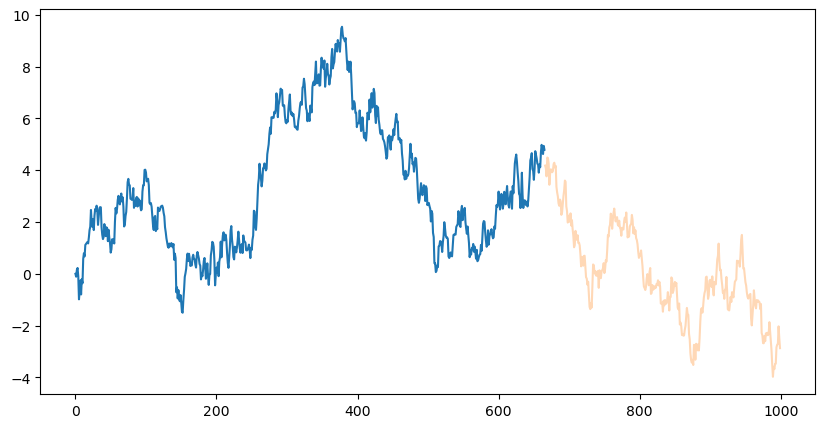

In [3]:
### Drift-Diffusion SDE

# Time discretization
Nt = 1000 # number of steps
dt =  0.2 # time step
tspan = np.linspace(0, Nt*dt, Nt)

# Drift and diffusion parameters
# Drift rate
# a = 0.3  
a = 0
# Noise level
sigma = 0.8

# Initialize the time series
X = np.zeros(Nt)
X[0] = 0  # Starting point
delta_x = []

np.random.seed(6)
# Generate the drift-diffusion time series
for t in range(1, Nt):
    dW =  np.random.normal()  # Wiener process (Brownian motion)
    dx = a * dt + sigma * np.sqrt(dt) * dW
    delta_x += [dx]
    X[t] = X[t-1] + dx

# Store the generated time-series in a pandas DataFrame
df = pd.DataFrame({'Time': tspan, 'X': X})

# Split the data into training and testing sets
train = df['X'][0:int(Nt/3*2)]
test = df['X'][int(Nt/3*2):]

plt.figure(figsize=(10, 5))
plt.plot(train, alpha = 1)
plt.plot([np.nan]*len(train)+list(test), alpha = 0.3)



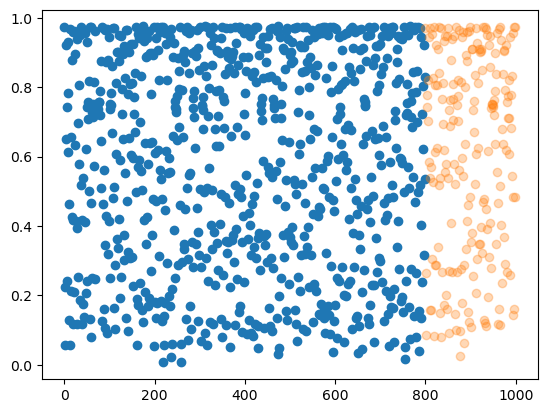

In [4]:
### Logistic Map
def logistic_map(r, x):
    return r * x * (1 - x)

### Manual differentiation
def logistic_map_diff(r, x):
    return np.abs(r * (1-2*x))

# Parameters

x = 0.5  # Initial condition
Nt = 1000  # Number of iterations

r = 3.9  # Control parameter
np.random.seed(6)
sigma = 0.0136 # Noise level

# r = 3.9  # Control parameter
# np.random.seed(6)
# sigma = 0.005 # Noise level

# r = 3.9  # Control parameter
# np.random.seed(6)
# sigma = 0.0 # Noise level

# r = 3.69  # Control parameter
# np.random.seed(2)
# sigma = 0.03 # Noise level

time_series = []
time_series_diff = []
mean_series = []
sigma_series = []
### Initial uncertainty is zero
x_diff = 0
for i in range(Nt):
    x_mean = logistic_map(r, x)
    x_sigma = x_diff * sigma
    x = logistic_map(r, x + sigma * np.random.normal())
    x_diff = logistic_map_diff(r, x)
    
    
    time_series.append(x)
    time_series_diff.append(x_diff)
    mean_series.append(x_mean)
    sigma_series.append(x_sigma)
    
df = pd.DataFrame({'X': time_series})
train = df['X'][0:int(Nt/5*4)]
test = df['X'][int(Nt/5*4):]

plt.plot(train, alpha = 1, lw = 0, marker = 'o')
plt.plot([np.nan]*len(train)+list(test), alpha = 0.3, lw = 0, marker = 'o')
plt.show()

## Running LLMTime and extracing logits

### Convert time series to strings

In [5]:
settings=SerializerSettings(base=10, prec=2, signed=True, time_sep=',', bit_sep='', minus_sign='-')

from data.serialize import serialize_arr
X = np.append(train.values, test.values) 
# rescale_factor = 1
# rescale_factor = 2
# rescale_factor = 0.3
# rescale_factor = 0.6
rescale_factor = 0.8
up_shift = 0.1
# up_shift = 0.15
rescaled_array = (X-X.min())/(X.max()-X.min()) * rescale_factor + up_shift
rescaled_true_mean_arr = (np.array(mean_series)-X.min())/(X.max()-X.min()) * rescale_factor + up_shift
rescaled_true_sigma_arr = (np.array(sigma_series)-X.min())/(X.max()-X.min()) * rescale_factor 

full_series = serialize_arr(rescaled_array, settings)
full_array = deserialize_str(full_series, settings) * 10

In [6]:
full_series

'89,14,27,63,85,29,70,74,60,86,20,47,89,14,27,63,81,44,88,19,43,88,26,61,83,43,88,19,42,86,30,66,76,57,87,24,52,89,19,44,88,23,53,89,20,43,88,26,60,86,29,70,71,67,76,50,89,20,48,89,15,30,69,71,68,76,56,88,29,69,70,69,69,69,71,70,71,71,68,74,62,81,51,89,19,47,89,22,55,89,18,37,81,44,89,16,35,82,43,87,30,70,71,71,74,64,80,49,89,22,51,89,17,33,76,59,83,39,83,37,81,44,87,25,58,87,30,69,75,63,83,40,85,34,77,55,89,20,48,89,17,36,73,63,83,34,76,59,85,35,76,58,85,28,69,73,64,79,50,89,14,25,56,88,23,58,87,28,67,78,55,88,22,51,90,19,43,86,26,62,82,38,82,44,87,23,57,88,25,62,83,31,73,62,83,40,83,48,89,14,24,59,87,20,48,89,24,60,84,35,77,55,88,24,53,89,19,48,89,10,14,21,46,88,24,60,85,33,77,55,88,25,58,87,23,55,89,11,14,27,63,82,41,86,30,70,72,70,69,73,62,82,33,75,66,79,47,89,10,14,33,74,63,83,38,84,36,81,46,88,20,51,89,15,34,78,54,88,23,55,89,17,38,83,32,73,70,68,74,60,84,38,82,46,89,19,41,84,35,79,51,89,15,32,71,71,70,73,65,80,50,89,16,34,78,51,89,14,29,68,75,56,88,19,42,85,37,80,50,89,19,41,87,

In [7]:
import torch
torch.cuda.empty_cache()
from models.llama import get_model_and_tokenizer, get_tokenizer

model, tokenizer = get_model_and_tokenizer('13b')


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
batch = tokenizer(
        [full_series], 
        return_tensors="pt",
        add_special_tokens=True
    )
batch = {k: v.cuda() for k, v in batch.items()}
input_ids = batch['input_ids'][0][1:]




### Compute Logits

In [123]:
with torch.no_grad():
    out = model(**batch)
    

with open(f"plot_output/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pkl", 'wb') as f:
            pickle.dump(out['logits'], f)

OutOfMemoryError: CUDA out of memory. Tried to allocate 688.00 MiB (GPU 0; 15.73 GiB total capacity; 14.32 GiB already allocated; 541.00 MiB free; 14.99 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Load saved logits

In [9]:
# ### hand-serialized brownian motion 13b
# with open('plot_output/2023-11-16_14-39-59.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
# ### hand-serialized brownian motion 13b, 0 drift
# with open('plot_output/2023-11-16_18-10-39.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

# ### hand-serialized brownian motion 13b, 0 drift, prec=2
# with open('plot_output/2023-11-16_18-14-01.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
### hand-serialized brownian motion 13b, 0 drift, prec=2, sigma = 0.8, seed = 6
# with open('plot_output/2023-11-17_03-24-00.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

### hand-serialized brownian motion 13b, 0 drift, prec=2, sigma = 0.8, seed = 6, rescaled_max = 2
# with open('plot_output/2023-11-17_03-28-16.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
# ## hand-serialized brownian motion 13b, 0 drift, prec=2, sigma = 0.8, seed = 6, rescaled_max = 0.3
# with open('plot_output/2023-12-02_22-40-32.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
# ## hand-serialized brownian motion 13b, 0 drift, prec=3, sigma = 0.8, seed = 6, rescaled_max = 0.3
# with open('plot_output/2023-12-03_01-25-21.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

# ## hand-serialized brownian motion 13b, 0 drift, prec=2, sigma = 0.8, seed = 6, rescaled_max = 0.3, up_shift = 0.15
# with open('plot_output/2023-12-03_01-40-31.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

# ## hand-serialized brownian motion 13b, 0 drift, prec=2, sigma = 0.8, seed = 6, rescaled_max = 0.6, up_shift = 0.15
# with open('plot_output/2023-12-03_02-39-22.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

# ## hand-serialized brownian motion 13b, prec=2, drift=0, sigma = 0.8, seed = 6, rescaled_max = 0.8
# with open('plot_output/2023-12-02_22-28-54.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

### hand-serialized logistic map, rescaled_max = 1
# with open('plot_output/2023-11-20_05-35-53.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
# ### hand-serialized logistic map, rescaled_max = 0.8
# with open('plot_output/2023-11-20_05-38-30.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

# ### hand-serialized logistic map, rescaled_max = 0.8, sigma = 0.011
# with open('plot_output/2023-11-29_19-06-15.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
## hand-serialized logistic map, rescaled_max = 0.8, sigma = 0.0136, prec = 2
with open('plot_output/2023-11-30_13-10-30.pkl', 'rb') as f:
    logit_mat = pickle.load(f)
    
# ## hand-serialized logistic map, rescaled_max = 0.8, sigma = 0.0136, prec = 3
# with open('plot_output/2023-12-02_17-40-35.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

# ## hand-serialized logistic map, rescaled_max = 0.8, sigma = 0.005, prec = 2
# with open('plot_output/2023-12-02_18-13-44.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
# ## hand-serialized logistic map, rescaled_max = 0.8, sigma = 0.005, prec = 3
# with open('plot_output/2023-12-02_18-17-19.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
# ## hand-serialized logistic map, rescaled_max = 0.8, r = 3.69, sigma = 0.03, seed = 2
# with open('plot_output/2023-12-01_01-38-57.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
# ### hand-serialized logistic map, rescaled_max = 0.8, r = 3.69, sigma = 0.03, seed = 3
# with open('plot_output/2023-12-02_18-38-35.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

# ## hand-serialized logistic map, rescaled_max = 0.8, r = 3.9, sigma = 0.0, seed = 6
# with open('plot_output/2023-12-01_02-35-40.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
    
### Take out only the good tokens, which is equivalent to setting bad tokens to -inf
# good_tokens_str = list("0123456789" + settings.time_sep + settings.bit_sep)
good_tokens_str = list("0123456789")
good_tokens = [tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]
logit_mat_good = logit_mat[:,:,good_tokens].clone()

### Visualize Softmax Prediction
### Multi-resolution Distribution
- [ ] If totally deterministic with no noise. Define loss using mean/mode as prediction
- [x] If there is small noise, we expect the spread to reflect local sensitivity

### Brownian Motion

In [125]:
### Load multiple digits to MultiResolutionPDF

#### Characterize ground truth distributions
true_sigma = sigma * np.sqrt(dt)/(X.max()-X.min()) * rescale_factor * 10
interval_mean = a * dt/(X.max()-X.min()) * rescale_factor
log_scale = False


T = 1
# discard first token
probs = torch.nn.functional.softmax(logit_mat_good[:,1:,:] / T, dim=-1)
string_labels = [label for label in good_tokens_str]
full_array_len = len(full_array)
good_tokens_len = len(good_tokens_str)

def digiprob_plotter(comma_idx=1):
    # Ensure comma_idx is within a valid range
    comma_idx = max(1, min(comma_idx, full_series.count(',') + 1))

    # Find the start and end indices of the value at the comma_idx-th comma
    comma_count = 0
    start_idx = None
    end_idx = None
    for i, char in enumerate(full_series):
        if char == ',':
            comma_count += 1
            if comma_count == comma_idx:
                start_idx = i + 1
            elif comma_count == comma_idx + 1:
                end_idx = i 
                break


    if start_idx is not None and end_idx is None:
        end_idx = len(full_series)

    # Calculate the number of digits to display in the softmax plot
    num_digits = end_idx - start_idx
    x_values = np.linspace(0, good_tokens_len, 300)
    true_mean = (interval_mean + rescaled_array[comma_idx-1]) * 10
    # print("mean", mean)
    gaussian = norm.pdf(x_values, true_mean, true_sigma)
    
    fig, axs = plt.subplots(2, 1, figsize=(12, 6))
    # Adjust the horizontal space between subplots
    plt.subplots_adjust(hspace=0.4)
    # Plot the full array with a marker on the selected value
    axs[0].plot(full_array, marker='o', color='black', markersize=3)
    axs[0].plot(comma_idx, full_array[comma_idx], color='r', marker='o')

    # Plot softmax distributions for each digit
    
    axs[1].set_xlabel("Digit")
    axs[1].set_ylabel("Probability Density")
    axs[1].set_title(full_series[start_idx-30:start_idx] + "?")
    pdf = MultiResolutionPDF()
    left_edge = 0
    previous_digit = 0
    previous_digit_prob = 1
    for i in range(num_digits):
        w = 0.1**i
        digit_idx = start_idx + i
        # print(f"previous_digit {previous_digit}")
        left_edge = left_edge + previous_digit * 10 * w
        x_coords = np.linspace(left_edge,left_edge+10 * w,good_tokens_len, endpoint = False) + 0.5 * w
        curr_digit = int(full_series[digit_idx])
        pdf_array = probs[:, digit_idx].cpu().numpy()[0]*previous_digit_prob/w
        ### save probability of the current digit, which is used to calculate the unconditioned PDF of the next digit
        curr_digit_prob = probs[:, digit_idx].cpu().numpy()[0][curr_digit]     
        previous_digit = curr_digit       
        previous_digit_prob = previous_digit_prob*curr_digit_prob
    
        # delete bins of the current digit unless it is the last digit
        if i < num_digits - 1:
            pdf_array  = np.delete(pdf_array , curr_digit)
            x_coords = np.delete(x_coords, curr_digit)
        
        pdf.add_bin(center_arr = x_coords, 
                    width_arr = np.ones(len(x_coords))*w, 
                    height_arr = pdf_array )
        
    pdf.normalize()
    pdf.compute_stats()
    pdf.plot(ax = axs[1], log_scale=log_scale)

    axs[1].plot(x_values, gaussian, color = 'r', label = 'Truth')
    plt.legend()
    plt.show()

# Adjust the range of the slider to match the number of commas in the series
num_commas = full_series.count(',')
interact(digiprob_plotter, comma_idx=(0, num_commas, 1))

interactive(children=(IntSlider(value=1, description='comma_idx', max=1000), Output()), _dom_classes=('widget-…

<function __main__.digiprob_plotter(comma_idx=1)>

#### Mean and sigma as in-context loss function

In [10]:
### Use MultiResolutionPDF to define loss 
#### Characterize ground truth distributions
interval_sigma = sigma * np.sqrt(dt)/(X.max()-X.min()) * rescale_factor
interval_mean = a * dt/(X.max()-X.min()) * rescale_factor

T = 1
# discard first token
probs = torch.nn.functional.softmax(logit_mat_good[:,1:,:] / T, dim=-1)
string_labels = [label for label in good_tokens_str]
full_array_len = len(full_array)
good_tokens_len = len(good_tokens_str)

def multi_resolution_predictor(comma_idx=1):
    # Ensure comma_idx is within a valid range
    comma_idx = max(1, min(comma_idx, full_series.count(',') + 1))

    # Find the start and end indices of the value at the comma_idx-th comma
    comma_count = 0
    start_idx = None
    end_idx = None
    for i, char in enumerate(full_series):
        if char == ',':
            comma_count += 1
            if comma_count == comma_idx:
                start_idx = i + 1
            elif comma_count == comma_idx + 1:
                end_idx = i 
                break


    if start_idx is not None and end_idx is None:
        end_idx = len(full_series)

    # Calculate the number of digits to display in the softmax plot
    num_digits = end_idx - start_idx
    true_mean = (interval_mean + rescaled_array[comma_idx-1]) * 10
    true_sigma = interval_sigma * 10
    pdf = MultiResolutionPDF()
    
    left_edge = 0
    previous_digit = 0
    previous_digit_prob = 1
    for i in range(num_digits):
        w = 0.1**i
        digit_idx = start_idx + i
        left_edge = left_edge + previous_digit * 10 * w
        x_coords = np.linspace(left_edge,left_edge+10 * w,good_tokens_len, endpoint = False) + 0.5 * w
        curr_digit = int(full_series[digit_idx])
        pdf_array = probs[:, digit_idx].cpu().numpy()[0]*previous_digit_prob/w
        ### save probability of the current digit, which is used to calculate the unconditioned PDF of the next digit
        curr_digit_prob = probs[:, digit_idx].cpu().numpy()[0][curr_digit]     
        previous_digit = curr_digit       
        previous_digit_prob = previous_digit_prob*curr_digit_prob
    
        # delete bins of the current digit unless it is the last digit
        if i < num_digits - 1:
            pdf_array  = np.delete(pdf_array , curr_digit)
            x_coords = np.delete(x_coords, curr_digit)
        
        pdf.add_bin(center_arr = x_coords, 
                    width_arr = np.ones(len(x_coords))*w, 
                    height_arr = pdf_array )


    pdf.normalize()
    pdf.compute_stats()
    return (true_mean, true_sigma, pdf.mean, pdf.mode, pdf.sigma)


true_mean_arr = []
true_sigma_arr = []
mean_arr = []
mode_arr = []
sigma_arr = []

num_commas = full_series.count(',')
for comma_idx in range(num_commas-1):
    true_mean, true_sigma, mean, mode, sigma = multi_resolution_predictor(comma_idx)
    true_mean_arr.append(true_mean)
    true_sigma_arr .append(true_sigma)
    mean_arr.append(mean)
    mode_arr.append(mode)
    sigma_arr.append(sigma)

# Convert lists to numpy arrays
true_mean_arr = np.array(true_mean_arr)
true_sigma_arr = np.array(true_sigma_arr)
mean_arr = np.array(mean_arr)
mode_arr = np.array(mode_arr)
sigma_arr = np.array(sigma_arr)


total area before normalization: 1.0000000443309545
total area before normalization: 1.0000000443309545
total area before normalization: 0.9999999295920133
total area before normalization: 0.9999999607447536
total area before normalization: 1.0000000176019967
total area before normalization: 1.000000039790757
total area before normalization: 1.0000000230967998
total area before normalization: 1.0000000008847565
total area before normalization: 0.9999999433755873
total area before normalization: 0.999999987287447
total area before normalization: 0.9999999781837685
total area before normalization: 0.9999999022344128
total area before normalization: 0.9999999592779205
total area before normalization: 0.9999999831430615
total area before normalization: 0.9999998872168362
total area before normalization: 1.0000001254142263
total area before normalization: 0.999999856937211
total area before normalization: 0.9999999093241059
total area before normalization: 0.9999999074731022
total area befo

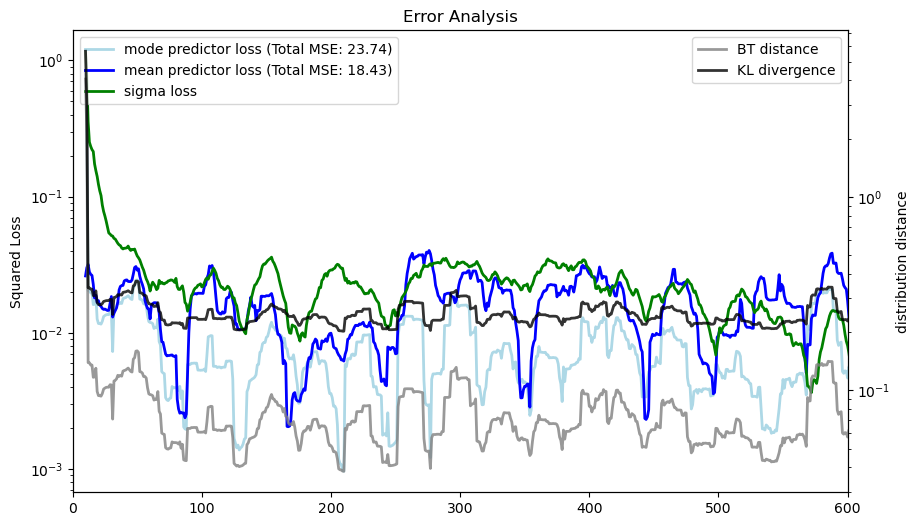

In [24]:
window_size = 20
xlog = 0
ylog = 1

top_hat_kernel = np.ones(window_size) / window_size
gaussian_kernel = norm.pdf(np.arange(window_size), loc=window_size // 2, scale=window_size / 6)
# kernel = gaussian_kernel
kernel = top_hat_kernel

# Errors for mean_arr
error_mean = (true_mean_arr - mean_arr) ** 2
averaged_error_mean = np.convolve(error_mean, kernel, mode='valid')

# Errors for mode_arr
error_mode = (true_mean_arr - mode_arr) ** 2
averaged_error_mode = np.convolve(error_mode, kernel, mode='valid')

# Errors sigma
error_sigma = (true_sigma_arr - sigma_arr) ** 2
averaged_error_sigma = np.convolve(error_sigma, kernel, mode='valid')

# Errors for Bhattacharya distance and KL divergence
BT_loss = error_mode / (true_sigma**2 + sigma**2) / 2 + np.log(sigma + true_sigma) - np.log(sigma * true_sigma)/2 - np.log(2)
averaged_BT_loss = np.convolve(BT_loss, kernel, mode='valid')

KL_loss = np.log(sigma/true_sigma) + (true_sigma**2 + error_mode)/(2*sigma**2) - 1/2
averaged_KL_loss = np.convolve(KL_loss, kernel, mode='valid')


fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the averaged errors
ax1.plot(np.arange(window_size//2, len(error_mode) - window_size//2 + 1), averaged_error_mode, label=f"mode predictor loss (Total MSE: {np.sum(error_mode):.2f})", linewidth=2, c='lightblue')
ax1.plot(np.arange(window_size//2, len(error_mean) - window_size//2 + 1), averaged_error_mean, label=f"mean predictor loss (Total MSE: {np.sum(error_mean):.2f})", linewidth=2, c='blue')
ax1.plot(np.arange(window_size//2, len(error_sigma) - window_size//2 + 1), averaged_error_sigma, label=f"sigma loss", linewidth=2, c='green')

ax1.set_ylabel("Squared Loss")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(np.arange(window_size//2, len(BT_loss) - window_size//2 + 1), averaged_BT_loss, label="BT distance", linewidth=2, c='gray', alpha = 0.8)
ax2.plot(np.arange(window_size//2, len(KL_loss) - window_size//2 + 1), averaged_KL_loss, label="KL divergence", linewidth=2, c='black', alpha = 0.8)

ax2.set_ylabel("distribution distance")
ax2.legend(loc='upper right')

if xlog:
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    
if ylog:
    ax1.set_yscale('log')
    ax2.set_yscale('log')

plt.xlim(0,600)

plt.xlabel("Time Steps Seen")
plt.title("Error Analysis")
plt.show()

### Logistic Map with Noise

In [21]:
### Load multiple digits to MultiResolutionPDF

T = 1
log_scale = 0
# discard first token
probs = torch.nn.functional.softmax(logit_mat_good[:,1:,:] / T, dim=-1)
good_tokens_len = len(good_tokens)
def digiprob_plotter(comma_idx=1):
    
    # Ensure comma_idx is within a valid range
    comma_idx = max(1, min(comma_idx, full_series.count(',') + 1))

    # Find the start and end indices of the value at the comma_idx-th comma
    comma_count = 0
    start_idx = None
    end_idx = None
    for i, char in enumerate(full_series):
        if char == ',':
            comma_count += 1
            if comma_count == comma_idx:
                start_idx = i + 1
            elif comma_count == comma_idx + 1:
                end_idx = i 
                break


    if start_idx is not None and end_idx is None:
        end_idx = len(full_series)

    # Calculate the number of digits to display in the softmax plot
    num_digits = end_idx - start_idx
    
    pdf = MultiResolutionPDF()
    # print('truth', truth)
    
    fig, axs = plt.subplots(2, 1, figsize=(12, 6))
    # Adjust the horizontal space between subplots
    plt.subplots_adjust(hspace=0.4)
    # Plot the full array with a marker on the selected value
    axs[0].plot(full_array, marker='o', color='black', markersize=3, lw = '0.1')
    axs[0].plot(comma_idx, full_array[comma_idx], color='r', marker='o')

    # Plot softmax distributions for each digit
    
    axs[1].set_xlabel("Digit")
    axs[1].set_ylabel("Probability Density")
    axs[1].set_title(full_series[start_idx-30:start_idx] + "?")
    left_edge = 0
    previous_digit = 0
    previous_digit_prob = 1
    for i in range(num_digits):
        w = 0.1**i
        digit_idx = start_idx + i
        # print(f"previous_digit {previous_digit}")
        left_edge = left_edge + previous_digit * 10 * w
        x_coords = np.linspace(left_edge,left_edge+10 * w,good_tokens_len, endpoint = False) + 0.5 * w
        curr_digit = int(full_series[digit_idx])
        pdf_array = probs[:, digit_idx].cpu().numpy()[0]*previous_digit_prob/w
        ### save probability of the current digit, which is used to calculate the unconditioned PDF of the next digit
        curr_digit_prob = probs[:, digit_idx].cpu().numpy()[0][curr_digit]     
        previous_digit = curr_digit       
        previous_digit_prob = previous_digit_prob*curr_digit_prob
    
        # delete bins of the current digit unless it is the last digit
        if i < num_digits - 1:
            pdf_array  = np.delete(pdf_array , curr_digit)
            x_coords = np.delete(x_coords, curr_digit)
        
        pdf.add_bin(center_arr = x_coords, 
                    width_arr = np.ones(len(x_coords))*w, 
                    height_arr = pdf_array )
        
    pdf.normalize()
    pdf.compute_stats()
    pdf.plot(ax = axs[1], log_scale=log_scale)
    # characterizing ground truth distribution
    true_mean = rescaled_true_mean_arr[comma_idx] * 10
    true_sigma = rescaled_true_sigma_arr[comma_idx] * 10
    x_values = np.linspace(0, good_tokens_len, 300)
    gaussian = norm.pdf(x_values, true_mean, true_sigma)
    axs[1].plot(x_values, gaussian, color = 'r', label = 'Truth')
    axs[1].vlines(true_mean, 0, np.max(gaussian), color = 'r')
    axs[1].legend()
    # return fig

# Adjust the range of the slider to match the number of commas in the series
num_commas = full_series.count(',')
interact(digiprob_plotter, comma_idx=(0, num_commas-1, 1))

interactive(children=(IntSlider(value=1, description='comma_idx', max=999), Output()), _dom_classes=('widget-i…

<function __main__.digiprob_plotter(comma_idx=1)>

### Mean and mode error as in-context loss function

In [93]:
### Use MultiResolutionPDF to define loss 

T = 1
# discard first token
probs = torch.nn.functional.softmax(logit_mat_good[:,1:,:] / T, dim=-1)
string_labels = [label for label in good_tokens_str]
good_tokens_len = len(good_tokens_str)

def multi_resolution_predictor(comma_idx=1):
    # Ensure comma_idx is within a valid range
    comma_idx = max(1, min(comma_idx, full_series.count(',') + 1))

    # Find the start and end indices of the value at the comma_idx-th comma
    comma_count = 0
    start_idx = None
    end_idx = None
    for i, char in enumerate(full_series):
        if char == ',':
            comma_count += 1
            if comma_count == comma_idx:
                start_idx = i + 1
            elif comma_count == comma_idx + 1:
                end_idx = i 
                break


    if start_idx is not None and end_idx is None:
        end_idx = len(full_series)

    # Calculate the number of digits to display in the softmax plot
    num_digits = end_idx - start_idx
    pdf = MultiResolutionPDF()
    
    left_edge = 0
    previous_digit = 0
    previous_digit_prob = 1
    for i in range(num_digits):
        w = 0.1**i
        digit_idx = start_idx + i
        left_edge = left_edge + previous_digit * 10 * w
        x_coords = np.linspace(left_edge,left_edge+10 * w,good_tokens_len, endpoint = False) + 0.5 * w
        curr_digit = int(full_series[digit_idx])
        pdf_array = probs[:, digit_idx].cpu().numpy()[0]*previous_digit_prob/w
        ### save probability of the current digit, which is used to calculate the unconditioned PDF of the next digit
        curr_digit_prob = probs[:, digit_idx].cpu().numpy()[0][curr_digit]     
        previous_digit = curr_digit       
        previous_digit_prob = previous_digit_prob*curr_digit_prob
    
        # delete bins of the current digit unless it is the last digit
        if i < num_digits - 1:
            pdf_array  = np.delete(pdf_array , curr_digit)
            x_coords = np.delete(x_coords, curr_digit)
        
        pdf.add_bin(center_arr = x_coords, 
                    width_arr = np.ones(len(x_coords))*w, 
                    height_arr = pdf_array )


    pdf.normalize()
    pdf.compute_stats()
    return (pdf.mean, pdf.mode, pdf.sigma)


mean_arr = []
mode_arr = []
sigma_arr = []

num_commas = full_series.count(',')
for comma_idx in range(num_commas):
    mean, mode, sigma = multi_resolution_predictor(comma_idx)
    mean_arr.append(mean)
    mode_arr.append(mode)
    sigma_arr.append(sigma)

# Convert lists to numpy arrays
mean_arr = np.array(mean_arr)
mode_arr = np.array(mode_arr)
sigma_arr = np.array(sigma_arr)


total area before normalization: 1.0000000163912772
total area before normalization: 1.0000000163912772
total area before normalization: 0.9999999627470969
total area before normalization: 0.999999949708581
total area before normalization: 0.9999999321997166
total area before normalization: 0.9999999940395355
total area before normalization: 0.9999999327585102
total area before normalization: 0.9999999990686775
total area before normalization: 0.9999999942258001
total area before normalization: 0.9999999828636646
total area before normalization: 0.9999999731779099
total area before normalization: 1.0000000106170774
total area before normalization: 0.9999999726191162
total area before normalization: 1.0000000271946192
total area before normalization: 1.0000001185573637
total area before normalization: 1.000000040512532
total area before normalization: 0.999999825214036
total area before normalization: 0.9999999402090907
total area before normalization: 0.9999999862164259
total area befo

### Sigma and Local Lyapunov

(0.0, 2.0)

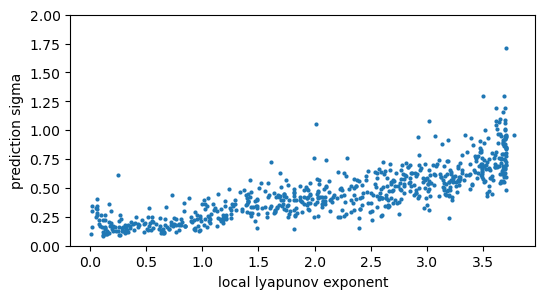

In [94]:
plt.figure(figsize=(6, 3))
plt.scatter(time_series_diff[300:-1],sigma_arr[301:], marker = '.', lw=0)
plt.xlabel('local lyapunov exponent')
plt.ylabel('prediction sigma')
plt.ylim(0, 2)
# plt.loglog()




Text(0.5, 0, 'prediction sigma')

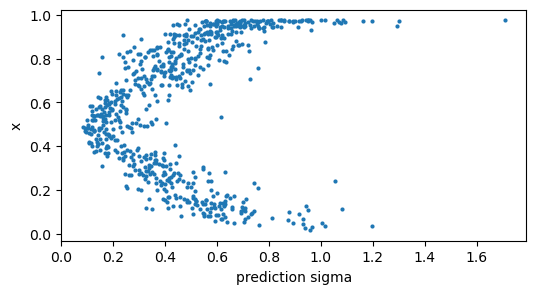

In [95]:
plt.figure(figsize=(6, 3))
plt.scatter(sigma_arr[301:], time_series[300:-1], marker = '.', lw=0)
plt.ylabel('x')
plt.xlabel('prediction sigma')
# plt.xlim(0, 0.7)

### NLL as in-context loss function

In [96]:
good_tokens_str = list("0123456789" + settings.time_sep + settings.bit_sep)
good_tokens = [tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]
bad_tokens = [i for i in range(len(tokenizer)) if i not in good_tokens]
logit_mat_biased = logit_mat.clone()
logit_mat_biased[:,:,bad_tokens] = -np.inf

logprobs = torch.nn.functional.log_softmax(logit_mat_biased, dim=-1)[0][:-1]
# logprob of the full trajectory
logprobs = logprobs[torch.arange(len(input_ids)), input_ids].cpu().numpy()
NLL = -logprobs

char_array = np.array(list(full_series))
comma_locations = np.where(char_array == ',')[0][:-1]+1

NLL_digit = -logprobs[comma_locations] \
            -logprobs[comma_locations+1] \
            -logprobs[comma_locations+2]

/tmp/ipykernel_553713/3159685391.py:29: RuntimeWarning: invalid value encountered in log
  BT_loss = error_mode / (true_sigma_arr**2 + sigma_arr**2) / 2 + np.log(sigma_arr + true_sigma_arr) - np.log(sigma_arr * true_sigma_arr)/2 - np.log(2)
/tmp/ipykernel_553713/3159685391.py:32: RuntimeWarning: invalid value encountered in log
  KL_loss = np.log(sigma_arr/true_sigma_arr) + (true_sigma_arr**2 + error_mode)/(2*sigma_arr**2) - 1/2


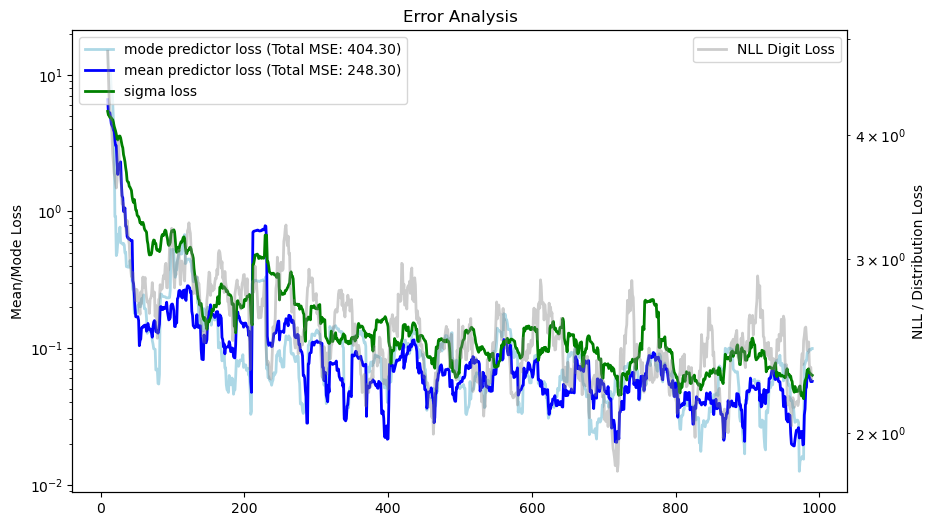

In [116]:
window_size = 20
xlog = 0
ylog = 1

true_mean_arr = rescaled_true_mean_arr*10
true_sigma_arr = rescaled_true_sigma_arr*10

top_hat_kernel = np.ones(window_size) / window_size
gaussian_kernel = norm.pdf(np.arange(window_size), loc=window_size // 2, scale=window_size / 6)
# kernel = gaussian_kernel
kernel = top_hat_kernel

# Errors for mean_arr
error_mean = (true_mean_arr - mean_arr) ** 2
averaged_error_mean = np.convolve(error_mean, kernel, mode='valid')

# Errors for mode_arr
error_mode = (true_mean_arr - mode_arr) ** 2
averaged_error_mode = np.convolve(error_mode, kernel, mode='valid')

# Errors sigma
error_sigma = (true_sigma_arr - sigma_arr) ** 2
averaged_error_sigma = np.convolve(error_sigma, kernel, mode='valid')

# Errors for NLL
averaged_nll_digit = np.convolve(NLL_digit, kernel, mode='valid')

# Errors for Bhattacharya distance and KL divergence
BT_loss = error_mode / (true_sigma_arr**2 + sigma_arr**2) / 2 + np.log(sigma_arr + true_sigma_arr) - np.log(sigma_arr * true_sigma_arr)/2 - np.log(2)
averaged_BT_loss = np.convolve(BT_loss, kernel, mode='valid')

KL_loss = np.log(sigma_arr/true_sigma_arr) + (true_sigma_arr**2 + error_mode)/(2*sigma_arr**2) - 1/2
averaged_KL_loss = np.convolve(KL_loss, kernel, mode='valid')

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the averaged errors
ax1.plot(np.arange(window_size//2, len(error_mode) - window_size//2 + 1), averaged_error_mode, label=f"mode predictor loss (Total MSE: {np.sum(error_mode):.2f})", linewidth=2, c='lightblue')
ax1.plot(np.arange(window_size//2, len(error_mean) - window_size//2 + 1), averaged_error_mean, label=f"mean predictor loss (Total MSE: {np.sum(error_mean):.2f})", linewidth=2, c='blue')
ax1.plot(np.arange(window_size//2, len(error_sigma) - window_size//2 + 1), averaged_error_sigma, label=f"sigma loss", linewidth=2, c='green')

ax1.set_ylabel("Mean/Mode Loss")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(np.arange(window_size//2, len(NLL_digit) - window_size//2 + 1), averaged_nll_digit, label="NLL Digit Loss", linewidth=2, c='gray', alpha = 0.4)
# ax2.plot(np.arange(window_size//2, len(BT_loss) - window_size//2 + 1), averaged_BT_loss, label="BT distance", linewidth=2, c='gray', alpha = 0.8)
# ax2.plot(np.arange(window_size//2, len(KL_loss) - window_size//2 + 1), averaged_KL_loss, label="KL divergence", linewidth=2, c='black', alpha = 0.8)

ax2.set_ylabel("NLL / Distribution Loss")
ax2.legend(loc='upper right')

if xlog:
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    
if ylog:
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    
# plt.xlim(0,200)
    
plt.xlabel("Time Steps Seen")
plt.title("Error Analysis")
plt.show()

